#  Global Terrorism Database (GTD)

Objetivo: entender estrutura, qualidade, padrões temporais e geográficos antes da modelagem.

In [1]:
# -*- coding: utf-8 -*-

# Importações principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Estilo visual
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Carregamento com encoding e otimizações conforme especificado
df = pd.read_csv('globalterrorismdb_0718dist.csv', encoding='ISO-8859-1', low_memory=False)

# Remoção de identificador único por não agregar valor analítico de padrões
if 'eventid' in df.columns:
    df = df.drop(columns=['eventid'])

# Tipagem explícita para colunas críticas; erros viram NaN para análise robusta
for col in ['nkill', 'nwound', 'iyear']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print('Dimensão:', df.shape)
df.info()
display(df.head())

Dimensão: (181691, 134)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Columns: 134 entries, iyear to related
dtypes: float64(55), int64(21), object(58)
memory usage: 185.7+ MB


,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,1970,1,0,NaN,0,NaN,78,Greece,8,Western Europe,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,1970,1,0,NaN,0,NaN,101,Japan,4,East Asia,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


## Análise de Nulos (> 20%)

Foco nas colunas com alta taxa de ausências para antecipar necessidades de imputação/remoção.

C:\Users\lucas\AppData\Local\Temp\ipykernel_40316\2545060835.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=high_missing.values * 100, y=high_missing.index, palette='viridis')


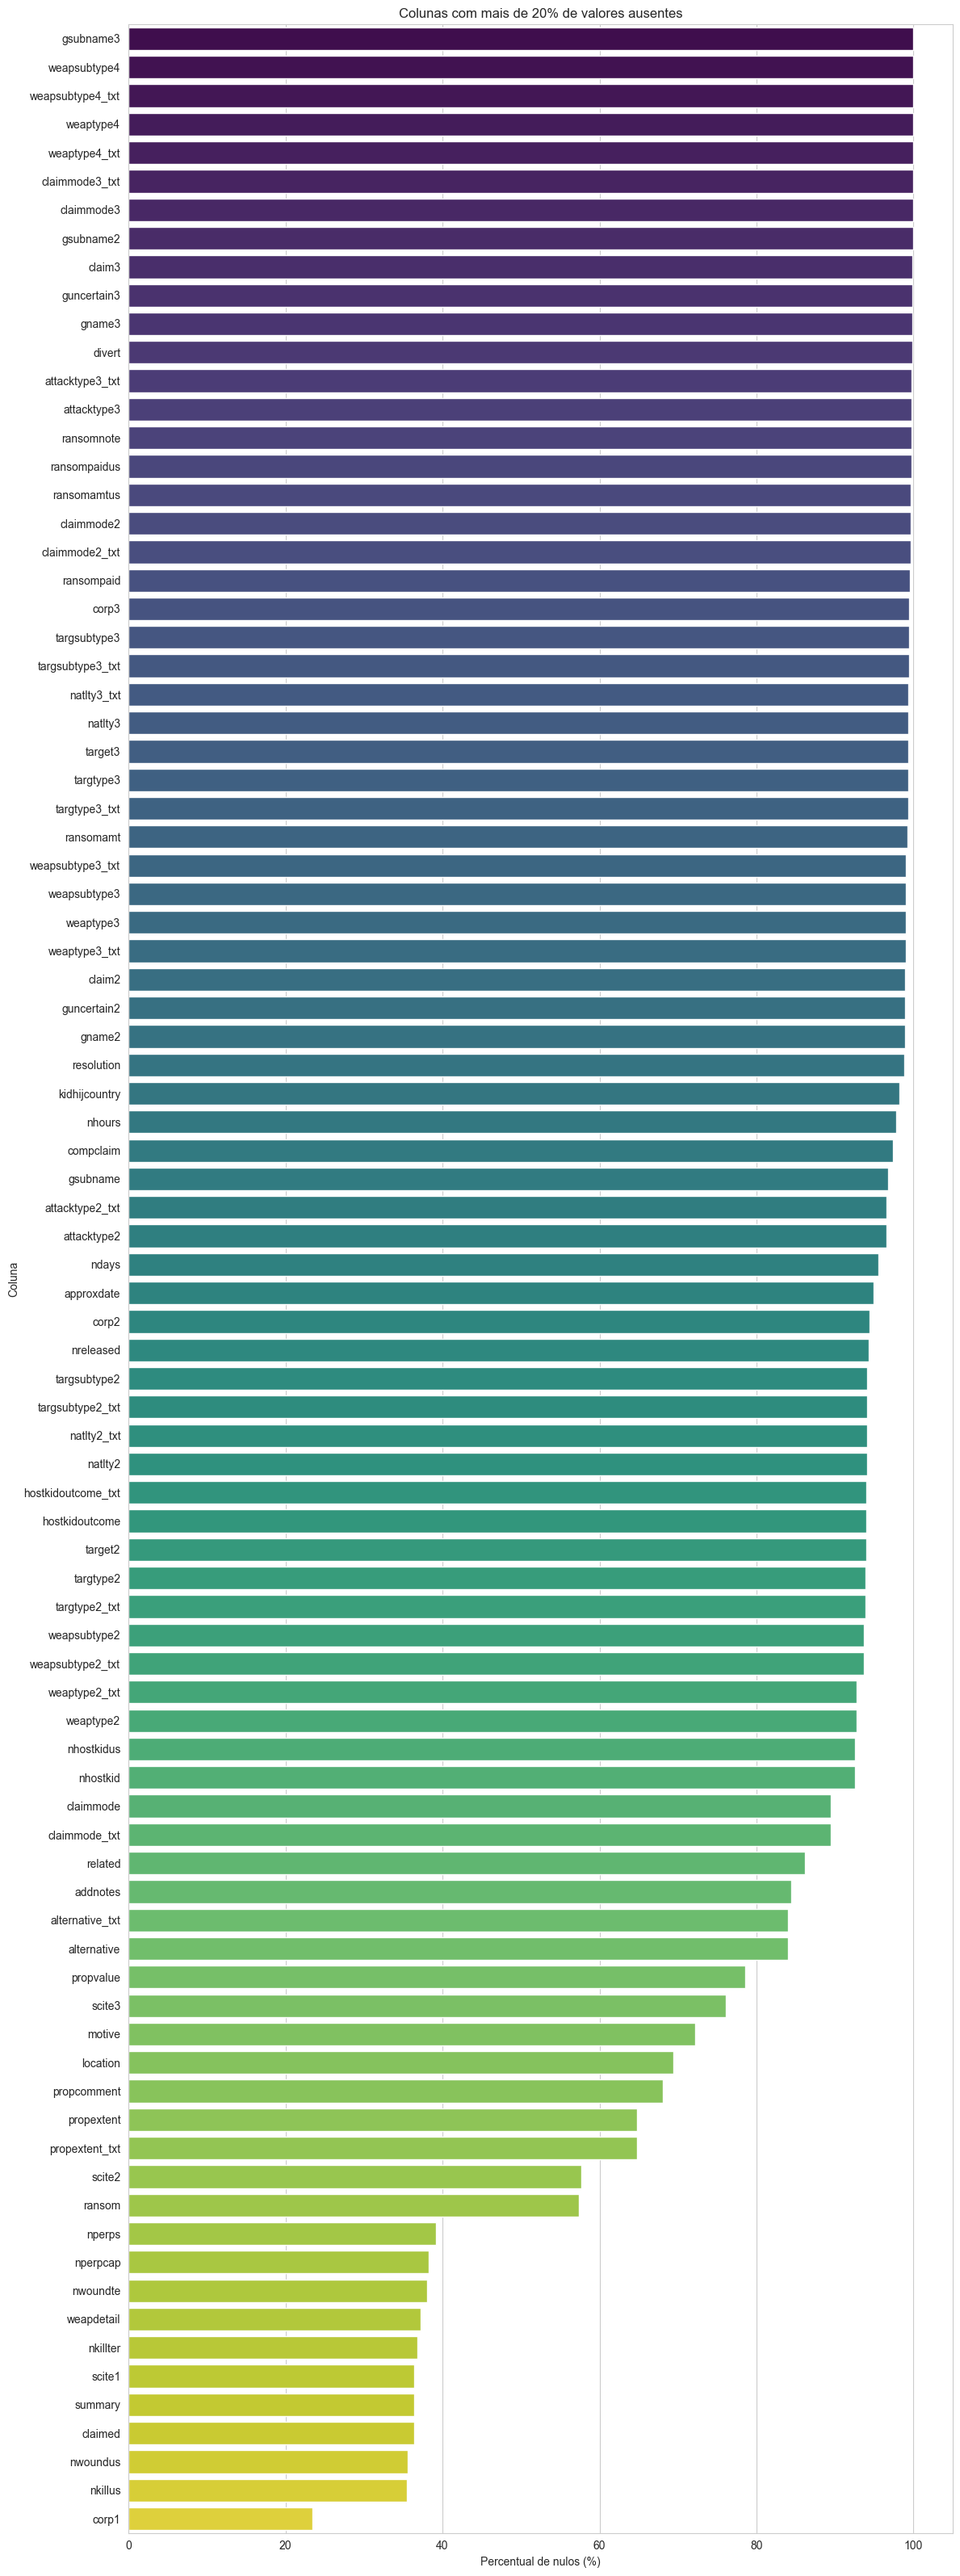

In [3]:
missing_pct = df.isna().mean()
high_missing = missing_pct[missing_pct > 0.20].sort_values(ascending=False)
if not high_missing.empty:
    plt.figure(figsize=(12, 32))
    sns.barplot(x=high_missing.values * 100, y=high_missing.index, palette='viridis')
    plt.xlabel('Percentual de nulos (%)')
    plt.ylabel('Coluna')
    plt.title('Colunas com mais de 20% de valores ausentes')
    plt.tight_layout()
    plt.show()
else:
    print('Nenhuma coluna com mais de 20% de dados faltantes.')

Observação: colunas com alta ausência exigem decisão específica (imputação, exclusão ou tratamento segmentado) antes da modelagem.

## Estatísticas Descritivas — `nkill` e `nwound`

Distribuições e indicadores sumários para vítimas fatais e feridos.

,nkill,nwound
count,171378.000000,165380.000000
mean,2.403272,3.167668
std,11.545741,35.949392
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.000000,2.000000
max,1570.000000,8191.000000


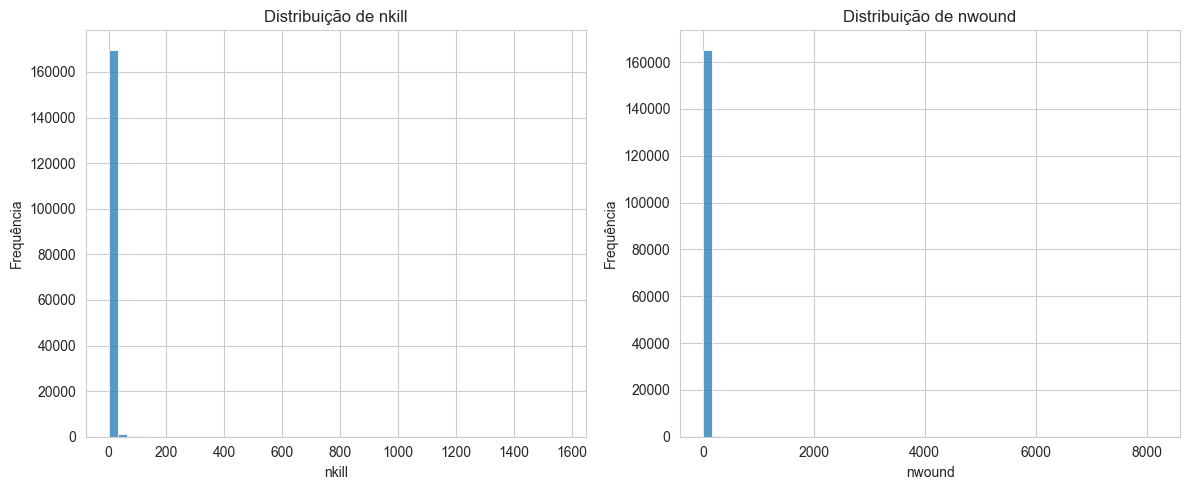

In [4]:
num_cols = [c for c in ['nkill', 'nwound'] if c in df.columns]
stats = df[num_cols].describe(percentiles=[0.25, 0.5, 0.75])
display(stats)
fig, axes = plt.subplots(1, len(num_cols), figsize=(12, 5))
if len(num_cols) == 1:
    axes = [axes]
for ax, c in zip(axes, num_cols):
    sns.histplot(df[c].dropna(), bins=50, ax=ax, kde=False)
    ax.set_title(f'Distribuição de {c}')
    ax.set_xlabel(c)
    ax.set_ylabel('Frequência')
plt.tight_layout()
plt.show()

Nota: é comum observar assimetria à direita (cauda longa) em contagens de vítimas; medidas robustas (mediana/quantis) são informativas.

## Tendências Temporais — Incidentes e Fatalidades por Ano

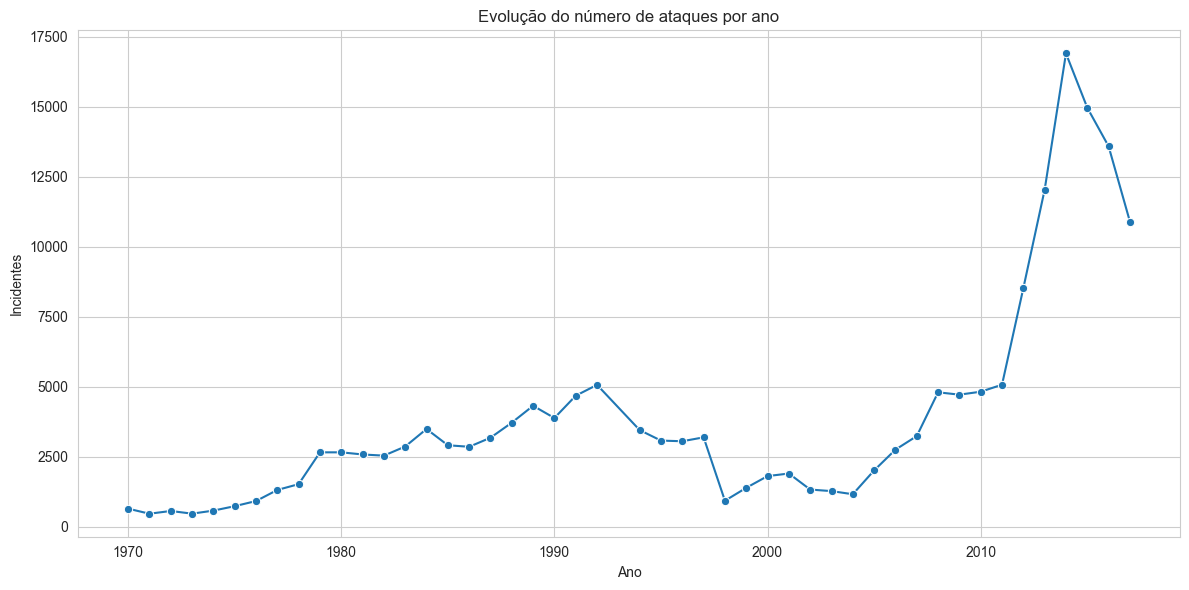

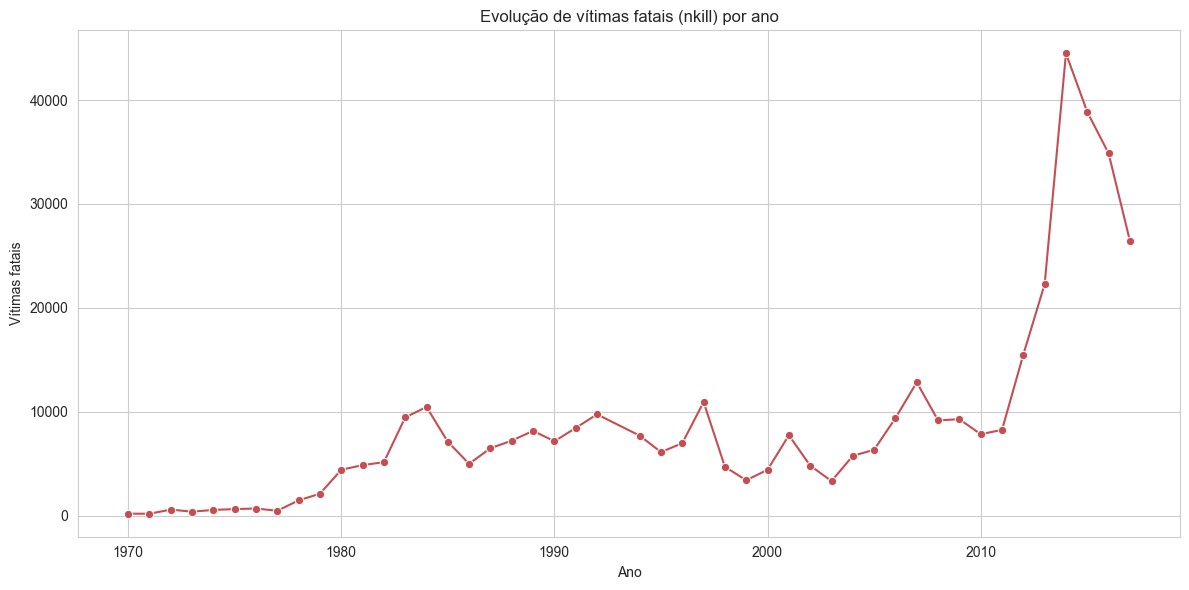

In [5]:
attacks_per_year = df.groupby('iyear').size()
plt.figure(figsize=(12, 6))
sns.lineplot(x=attacks_per_year.index, y=attacks_per_year.values, marker='o')
plt.title('Evolução do número de ataques por ano')
plt.xlabel('Ano')
plt.ylabel('Incidentes')
plt.tight_layout()
plt.show()
fatalities_per_year = df.groupby('iyear')['nkill'].sum(min_count=1) if 'nkill' in df.columns else pd.Series(dtype=float)
if not fatalities_per_year.empty:
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=fatalities_per_year.index, y=fatalities_per_year.values, marker='o', color='#C44E52')
    plt.title('Evolução de vítimas fatais (nkill) por ano')
    plt.xlabel('Ano')
    plt.ylabel('Vítimas fatais')
    plt.tight_layout()
    plt.show()
else:
    print('Coluna nkill indisponível para série histórica de fatalidades.')

Insight: a inspeção visual permite identificar picos e quedas marcantes; variações estruturais por década costumam refletir eventos geopolíticos e mudanças no registro de dados.

## Distribuições Categóricas e Geográficas

C:\Users\lucas\AppData\Local\Temp\ipykernel_40316\2578130651.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette='crest')


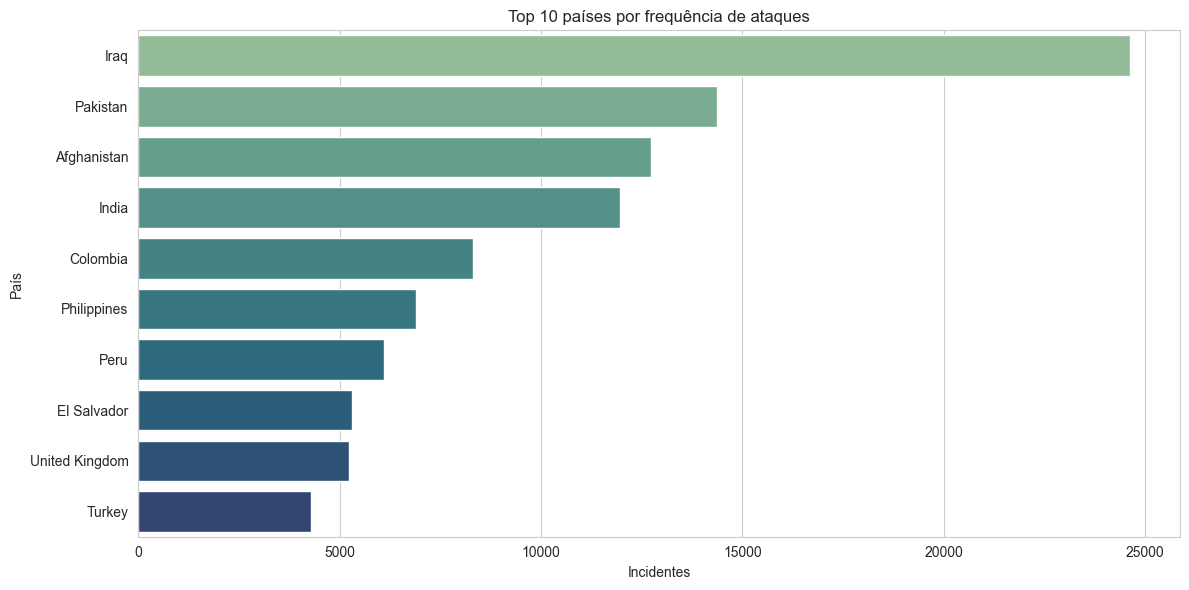

C:\Users\lucas\AppData\Local\Temp\ipykernel_40316\2578130651.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['attacktype1_txt'], order=order_types, palette='Set2')


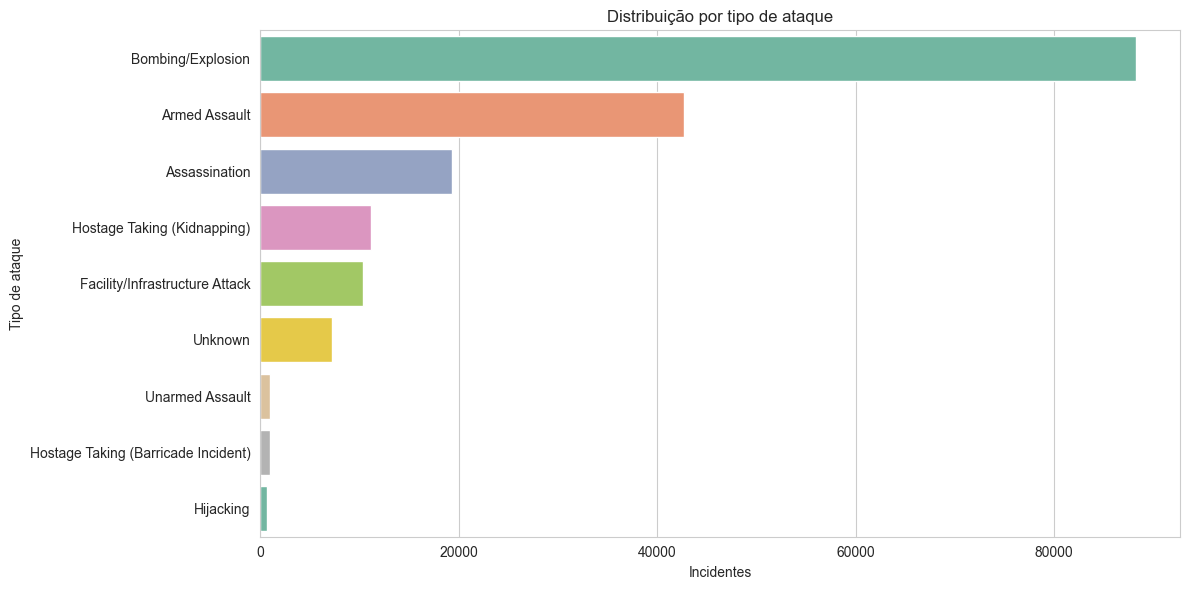

C:\Users\lucas\AppData\Local\Temp\ipykernel_40316\2578130651.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[reg_col], order=order_regions, palette='mako')


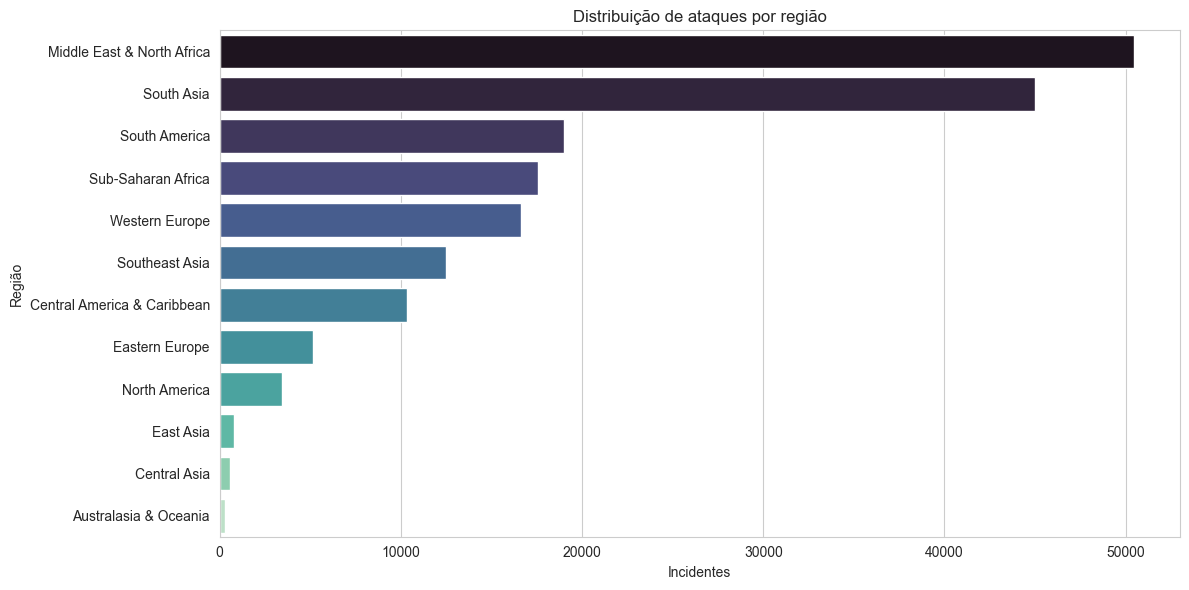

In [6]:
if 'country_txt' in df.columns:
    top_countries = df['country_txt'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_countries.values, y=top_countries.index, palette='crest')
    plt.title('Top 10 países por frequência de ataques')
    plt.xlabel('Incidentes')
    plt.ylabel('País')
    plt.tight_layout()
    plt.show()
else:
    print('Coluna country_txt indisponível.')

if 'attacktype1_txt' in df.columns:
    order_types = df['attacktype1_txt'].value_counts().index
    plt.figure(figsize=(12, 6))
    sns.countplot(y=df['attacktype1_txt'], order=order_types, palette='Set2')
    plt.title('Distribuição por tipo de ataque')
    plt.xlabel('Incidentes')
    plt.ylabel('Tipo de ataque')
    plt.tight_layout()
    plt.show()
else:
    print('Coluna attacktype1_txt indisponível.')

reg_col = 'region_txt' if 'region_txt' in df.columns else ('region' if 'region' in df.columns else None)
if reg_col:
    order_regions = df[reg_col].value_counts().index
    plt.figure(figsize=(12, 6))
    sns.countplot(y=df[reg_col], order=order_regions, palette='mako')
    plt.title('Distribuição de ataques por região')
    plt.xlabel('Incidentes')
    plt.ylabel('Região')
    plt.tight_layout()
    plt.show()
else:
    print('Colunas de região indisponíveis.')

Insight: a concentração por países/regiões e tipos de ataque ajuda a priorizar variáveis explicativas e estratégias de modelagem subsequentes.

## Heatmap Temporal (Região × Ano)

Visualiza migração de incidência ao longo das décadas por região.

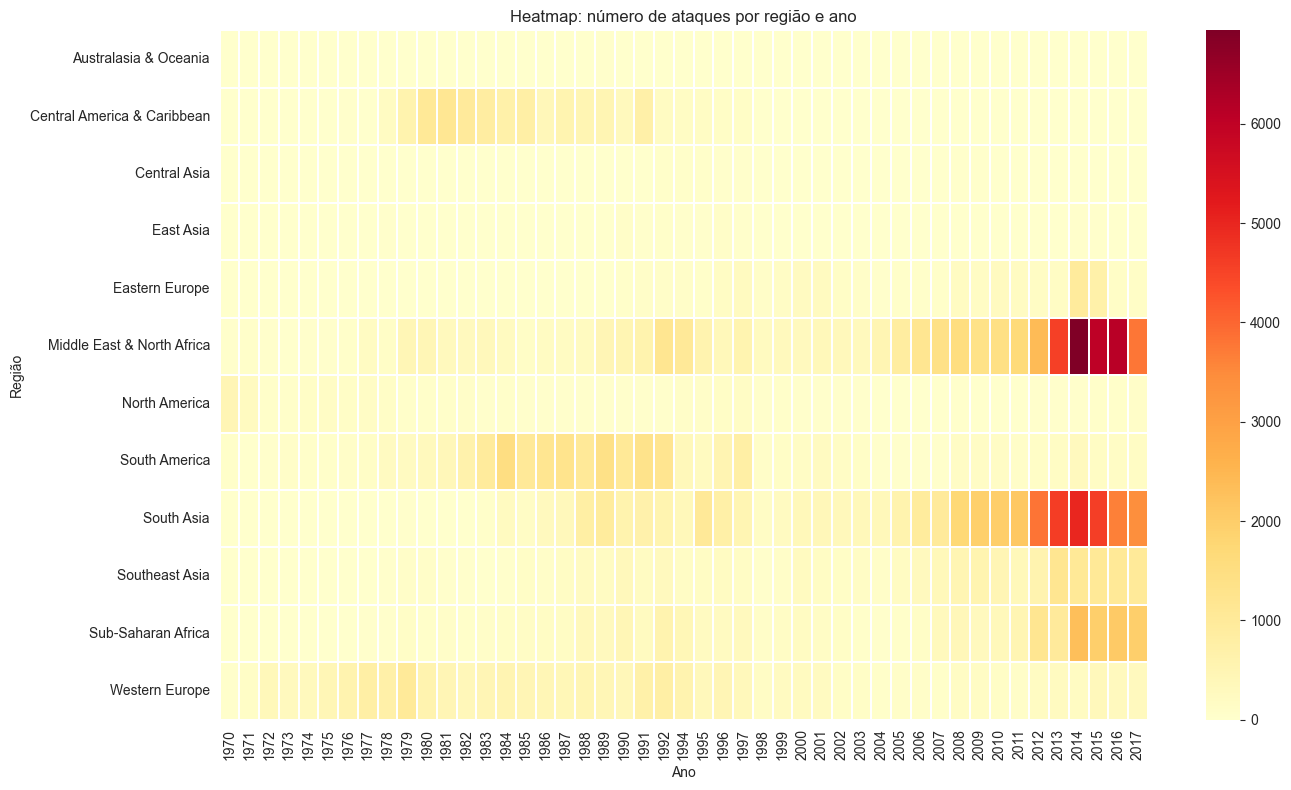

In [7]:
reg_col = 'region_txt' if 'region_txt' in df.columns else ('region' if 'region' in df.columns else None)
if reg_col and 'iyear' in df.columns:
    counts_df = df.assign(count=1)
    pivot = counts_df.pivot_table(index=reg_col, columns='iyear', values='count', aggfunc='sum', fill_value=0)
    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot, cmap='YlOrRd', linewidths=0.3)
    plt.title('Heatmap: número de ataques por região e ano')
    plt.xlabel('Ano')
    plt.ylabel('Região')
    plt.tight_layout()
    plt.show()
else:
    print('Impossível gerar heatmap: verifique disponibilidade de region_txt/region e iyear.')

Insight: padrões de calor evidenciam deslocamentos de incidência; quadrantes mais intensos sugerem períodos/locais críticos para investigação.

## Matriz de Correlação (nkill, nwound, iyear)

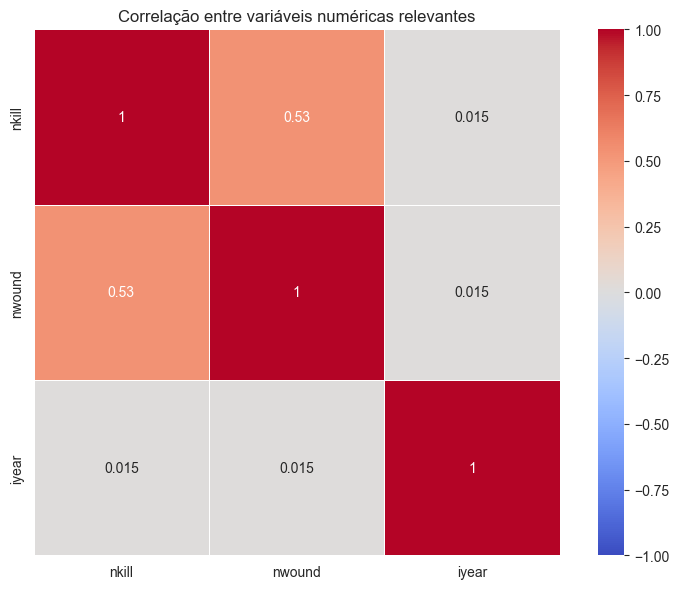

In [8]:
corr_cols = [c for c in ['nkill', 'nwound', 'iyear'] if c in df.columns]
if len(corr_cols) >= 2:
    corr = df[corr_cols].corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=0.5)
    plt.title('Correlação entre variáveis numéricas relevantes')
    plt.tight_layout()
    plt.show()
else:
    print('Colunas insuficientes para matriz de correlação.')

Insight: espera-se correlação positiva entre `nkill` e `nwound`; relação com `iyear` tende a refletir tendências agregadas e mudanças de escala temporal.